<a href="https://colab.research.google.com/github/caoTayTang/ML251/blob/main/notebooks/3_HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nhận Dạng Chữ Số Qua Giọng Nói với Mô Hình HMM
**Nhóm**: ML4U

**Ngày**: 09/09/2025

**Môn học**: CO3117

**GVHD**: TS. Lê Thành Sách

**Github**: https://github.com/caoTayTang/ML251

**Landing page**: https://caotaytang.github.io/ML-251/

---

## 📑 Mục lục
- [1. Tổng quan Project](#overview)
- [2. Cài đặt & Thiết lập](#setup)
- [3. Phân tích Dữ liệu Khám phá (EDA)](#eda)
- [4. Trích xuất Đặc trưng với MFCC](#features)
- [5. Tải và Chuẩn bị Dữ liệu](#dataloader)
- [6. Huấn luyện Mô hình HMM](#training)
- [7. Đánh giá Mô hình](#evaluation)
- [8. Demo Tương tác](#demo)
- [9. Kết luận](#conclusion)

<a id="overview"></a>
## 1. Tổng quan Project

Trong notebook này, chúng ta sẽ xây dựng một hệ thống **nhận dạng tiếng nói chữ số** hoàn chỉnh. Mục tiêu là phân loại các đoạn ghi âm giọng nói của các chữ số (từ 0 đến 9) vào đúng nhãn của chúng.

Đây là project mở rộng của môn học Máy học, tập trung vào việc triển khai một kỹ thuật mạnh mẽ và kinh điển trong mô hình hóa chuỗi (sequence modeling): **Mô hình Markov Ẩn (HMM)**.

### **Luồng xử lý của Project (Pipeline):**
1.  **Tải Dữ liệu**: Sử dụng bộ dữ liệu Free Spoken Digit Dataset (FSDD).
2.  **Phân tích Dữ liệu Khám phá (EDA)**: Phân tích và trực quan hóa dạng sóng (waveform) và phổ tần số (spectrogram) của tín hiệu âm thanh để hiểu rõ đặc tính của dữ liệu.
3.  **Trích xuất Đặc trưng**: Chuyển đổi tín hiệu âm thanh thô thành một dạng biểu diễn cô đọng và hiệu quả hơn bằng cách sử dụng **Hệ số Mel-Frequency Cepstral (MFCCs)**.
4.  **Huấn luyện Mô hình**: Huấn luyện mười mô hình HMM riêng biệt, mỗi mô hình cho một chữ số (từ 0 đến 9), trên các đặc trưng MFCC đã trích xuất.
5.  **Đánh giá**: Đo lường hiệu suất của hệ thống trên tập dữ liệu kiểm tra (test set) bằng độ chính xác (accuracy).
6.  **Triển khai Demo**: Xây dựng một giao diện web tương tác bằng Gradio để cho phép dự đoán trong thời gian thực với các mẫu âm thanh mới.

---

## 1. ⚙️ Thiết lập Môi trường

Trong phần này, chúng ta sẽ nhập tất cả các thư viện cần thiết, định nghĩa các hằng số và tải tập dữ liệu.

In [1]:
!git clone https://github.com/caoTayTang/ML251

Cloning into 'ML251'...
remote: Enumerating objects: 28116, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 28116 (delta 47), reused 66 (delta 30), pack-reused 28004 (from 4)
Receiving objects: 100% (28116/28116), 531.78 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (456/456), done.
Updating files: 100% (27377/27377), done.
Encountered 1 file(s) that should have been pointers, but weren't:
	requirements.txt


In [2]:
%cd ML251/data/audio
!./download_FSDD.sh

/content/ML251/data/audio
[INFO] Downloading FSDD into /content/ML251/data/audio ...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15.5M  100 15.5M    0     0  26.8M      0 --:--:-- --:--:-- --:--:-- 26.8M
Archive:  fsdd.zip
  inflating: .gitignore              
  inflating: README.md               
  inflating: __init__.py             
  inflating: acquire_data/say_numbers_prompt.py  
  inflating: acquire_data/split_and_label_numbers.py  
  inflating: metadata.py             
  inflating: pip_requirements.txt    
  inflating: recordings/0_george_0.wav  
  inflating: recordings/0_george_1.wav  
  inflating: recordings/0_george_10.wav  
  inflating: recordings/0_george_11.wav  
  inflating: recordings/0_george_12.wav  
  inflating: recordings/0_george_13.wav  
  inflating: recordings/0_george_14

### 1.1. Nhập các thư viện cần thiết


In [3]:
%pip install numpy matplotlib scipy librosa

In [4]:
%cd /content/ML251

/content/ML251


In [5]:
# --- Core and System Libraries ---
import sys
import os
import collections
import joblib
import re

# --- Audio and Data Visualization ---
from IPython.display import Audio
import librosa
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pandas as pd

# --- Machine Learning ---
from sklearn.model_selection import train_test_split

# --- Custom Modules ---
from ML251.src.acoustic import FSDD
from ML251.src.constants import DATA_DIR, FEATURES_DIR, MODELS_CKPT
from ML251.src.demo import app
from ML251.src.acoustic.hmm import HMMTrainer


### 1.2. Cấu hình và các hàm hỗ trợ

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

### Reproducibility
Để đảm bảo các thí nghiệm có khả năng reproduce lại được thì cần set SEED cố định

In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


    
<a id="eda"></a>
## 3. Phân tích Dữ liệu Khám phá (EDA)

Trước khi xây dựng mô hình, bước đầu tiên và quan trọng nhất là tìm hiểu bộ dữ liệu mà chúng ta đang làm việc. EDA giúp chúng ta phát hiện các mẫu, các điểm bất thường và các đặc tính chính của file âm thanh.

Trong phần này, chúng ta sẽ:
-   Tải một vài mẫu âm thanh ngẫu nhiên từ các người nói khác nhau.
-   Nghe các đoạn ghi âm để có cảm nhận định tính về dữ liệu.
-   Trực quan hóa **dạng sóng (waveform)** (biên độ theo thời gian) và **phép biến đổi Fourier (FFT)** của nó (thành phần tần số) để phân tích các thuộc tính trong cả miền thời gian và miền tần số.

Hãy bắt đầu bằng cách tải và nghe thử một vài mẫu âm thanh ngẫu nhiên.

  

In [8]:
np.random.seed(SEED)
samples = np.random.choice(list(sorted(DATA_DIR.glob("*.wav"))), size=3, replace=False)
metadata = [sample.name.split("_", 2)[:2] for sample in samples]
print(samples)

[PosixPath('/content/ML251/data/audio/recordings/6_george_1.wav')
 PosixPath('/content/ML251/data/audio/recordings/3_yweweler_45.wav')
 PosixPath('/content/ML251/data/audio/recordings/6_george_24.wav')]


In [9]:
ys = []
sr = 8000  # match FSDD sampling rate
for sample in samples:
    y, _ = librosa.load(sample, sr=sr)
    ys.append(y)

In [10]:
for y, (word, speaker) in zip(ys, metadata):
    print(f'Sampling rate: {sr}hz')
    print(f'Duration: {librosa.get_duration(y=y, sr=sr)}s')
    print(f'Audio shape: {y.shape}')
    print(f'Speaker: {speaker}, word: {word}')
    display(Audio(y, rate=sr))

Sampling rate: 8000hz
Duration: 0.46825s
Audio shape: (3746,)
Speaker: george, word: 6


Sampling rate: 8000hz
Duration: 0.336s
Audio shape: (2688,)
Speaker: yweweler, word: 3


Sampling rate: 8000hz
Duration: 0.3985s
Audio shape: (3188,)
Speaker: george, word: 6


> 📝 **Phân tích Thuộc tính Tín hiệu Âm thanh:**
> - **Shape của Audio:** Dạng `(n,)` cho thấy tín hiệu âm thanh là **đơn kênh (mono)**, tức là chỉ có một luồng dữ liệu âm thanh.
> - **Thời lượng (Duration):** Được tính bằng công thức:
>   $$ \text{Thời lượng} = \frac{\text{Số mẫu (n)}}{\text{Tần số lấy mẫu (sampling rate)}} $$
>   Với tần số lấy mẫu là 8000 Hz, thời lượng của mỗi đoạn ghi âm xấp xỉ **0.4 giây**.

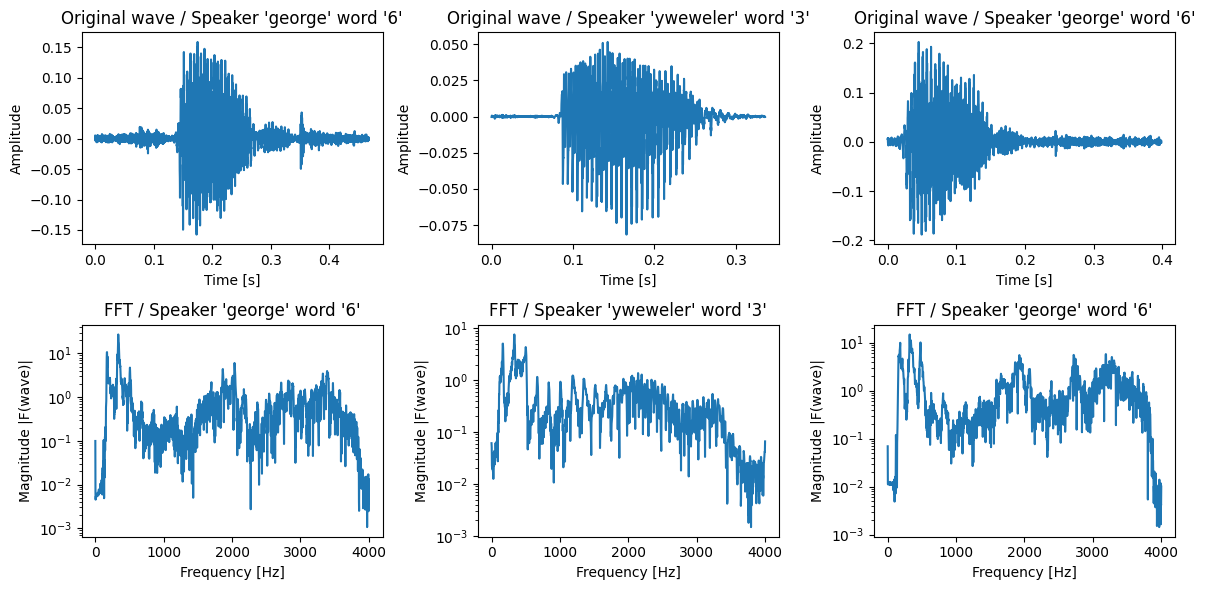

In [11]:
def plot_sound(ys, axes):
    # axes shape: (2, N) → 2 rows, N columns
    n = len(ys)

    for j, ((word, speaker), data) in enumerate(zip(metadata, ys)):
        ax_wave = axes[0, j]
        ax_fft  = axes[1, j]

        # waveform
        ax_wave.plot(np.linspace(0, len(data)/sr, len(data)), data)
        ax_wave.set_ylabel("Amplitude")
        ax_wave.set_xlabel("Time [s]")
        ax_wave.set_title(f"Original wave / Speaker '{speaker}' word '{word}'")

        # FFT
        freqs = np.fft.rfftfreq(len(data), 1/sr)
        ax_fft.semilogy(freqs, np.abs(np.fft.rfft(data)))
        ax_fft.set_ylabel("Magnitude |F(wave)|")
        ax_fft.set_xlabel("Frequency [Hz]")
        ax_fft.set_title(f"FFT / Speaker '{speaker}' word '{word}'")


fig, axes = plt.subplots(2, len(ys), figsize=(4*len(ys), 6))
plot_sound(ys, axes)
plt.tight_layout()
plt.show()

> 📊 **Phân tích chi tiết về Dạng sóng & FFT:**
>
> Các biểu đồ trên cho thấy tín hiệu âm thanh thô của các chữ số được nói bởi những người khác nhau. Hàng trên là **dạng sóng** trong miền thời gian, hàng dưới là **phổ tần số** sau khi áp dụng biến đổi Fourier (FFT).
>
> - **Dạng sóng (Waveform - Miền thời gian):**
>   - **Sự khác biệt giữa các người nói (Inter-speaker variation):** So sánh cách phát âm của `george` (số '6') và `yweweler` (số '3'). Ta thấy **biên độ** (độ lớn) của `yweweler` (chỉ khoảng 0.05) nhỏ hơn nhiều so với `george` (đạt tới 0.15 - 0.2).
>   - **Sự khác biệt ngay trong cùng một người nói (Intra-speaker variation):** Rất đáng chú ý là hai lần phát âm số '6' của cùng một người nói `george` lại có **dạng sóng hoàn toàn khác nhau** về cả *thời lượng* và *biên độ*. Điều này cho thấy tín hiệu thô rất không ổn định.
>   - **Kết luận:** Dạng sóng thô biến đổi rất lớn, ngay cả với cùng một từ, cùng một người nói. Do đó, rất khó để sử dụng trực tiếp đặc trưng này để nhận dạng.
>
> - **Biến đổi Fourier (FFT - Miền tần số):**
>   - **Phân bổ năng lượng:** Hầu hết năng lượng của tín hiệu giọng nói đều tập trung ở các tần số thấp (dưới 1000 Hz), đây là đặc điểm chung của tiếng nói con người (tần số cơ bản).
>   - **Sự khác biệt về phổ:** Phổ tần số của số '3' (`yweweler`) có các đỉnh (formant) khác biệt so với số '6' (`george`). Quan trọng hơn, hai lần phát âm số '6' của `george` dù có một số nét tương đồng nhưng **không hề giống nhau hoàn toàn**.
>   - **Kết luận:** Phổ tần số cung cấp một "dấu vân tay" cho âm thanh nhưng vẫn còn rất phức tạp và nhiễu.
>
> ➜ **Kết luận chung:** Dữ liệu âm thanh thô rất biến động. Cả biểu diễn trong miền thời gian (waveform) và miền tần số (FFT) đều không đủ ổn định để làm đặc trưng đầu vào cho mô hình học máy. Điều này khẳng định sự cần thiết phải có một bước **trích xuất đặc trưng** mạnh mẽ hơn, như MFCC, để tìm ra những thuộc tính bất biến và cô đọng hơn.

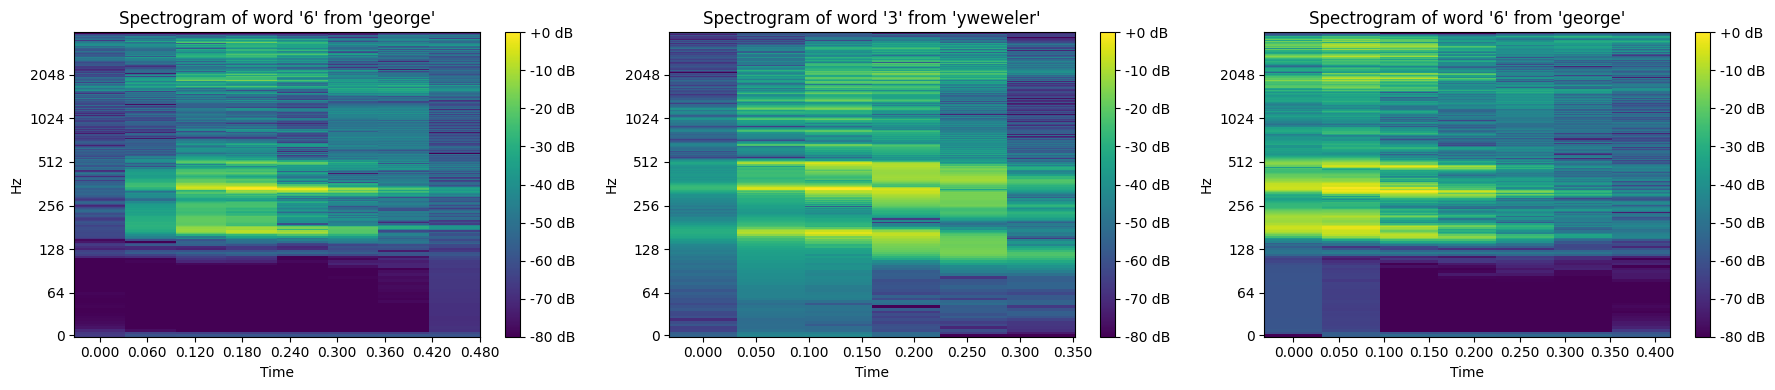

In [12]:
# Spectrogram
# Thay đổi layout từ (số hàng, 1) thành (1, số cột)
# Điều chỉnh figsize để biểu đồ rộng hơn thay vì cao hơn
fig, axes = plt.subplots(1, len(ys), figsize=(6 * len(ys), 4))

# Xử lý trường hợp chỉ có 1 biểu đồ (axes không phải là array)
if len(ys) == 1:
    axes = [axes]

for i, ((word, speaker), y) in enumerate(zip(metadata, ys)):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Vẽ trên axis tương ứng trong layout ngang
    img1 = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=axes[i], cmap='viridis')

    axes[i].set_title(f"Spectrogram of word '{word}' from '{speaker}'")

    fig.colorbar(img1, ax=axes[i], format="%+1.f dB")

# Giúp các biểu đồ không bị chồng chéo
plt.tight_layout()
plt.show()

> 📈 **Phân tích chi tiết về Spectrogram:**
>
> Spectrogram là một công cụ cực kỳ mạnh mẽ, nó biểu diễn năng lượng của các **tần số** (`trục y`) thay đổi theo **thời gian** (`trục x`). Cường độ màu cho biết năng lượng (vàng là cao, tím/đen là thấp).
>
> Dựa vào 3 biểu đồ trên, chúng ta có thể rút ra những nhận xét quan trọng sau:
>
> - **1. Phân biệt các chữ số khác nhau (Inter-word):**
>   - So sánh `Spectrogram 1 (số '6')` và `Spectrogram 2 (số '3')`, ta thấy **"acoustic fingerprint"** của chúng hoàn toàn khác nhau.
>   - **Số '6' (`george`):** Có một vùng năng lượng lớn, tập trung ở tần số thấp (khoảng 256-512 Hz) và di chuyển nhẹ theo thời gian.
>   - **Số '3' (`yweweler`):** Có các dải năng lượng (formant) nằm ngang và ổn định hơn, cho thấy cấu trúc nguyên âm khác biệt.
>   - ➜ **Kết luận:** Mỗi chữ số tạo ra một mẫu phổ (pattern) riêng biệt, đây chính là cơ sở để mô hình có thể học và phân loại.
>
> - **2. Sự biến đổi ngay cả khi cùng một người nói (Intra-speaker):**
>   - Đây là điểm quan sát **quan trọng nhất**. So sánh `Spectrogram 1` và `Spectrogram 3` (cùng là `george` nói số '6'). Mặc dù là cùng một từ, cùng một người nói, nhưng hai spectrogram này **không hề giống hệt nhau**.
>   - **Khác biệt cụ thể:**
>     - *Thời điểm bắt đầu:* Năng lượng bắt đầu xuất hiện ở thời điểm khác nhau.
>     - *Hình dạng dải năng lượng:* Các "vân" màu sáng có hình dạng và cường độ hơi khác nhau.
>     - *Thời lượng:* Tổng thời gian phát âm cũng có sự chênh lệch.
>   - -> **Kết luận:** Điều này cho thấy sự biến đổi tự nhiên trong giọng nói. Một mô hình tốt phải học được **bản chất tổng quát** của chữ số '6' chứ không phải học thuộc lòng một cách phát âm cụ thể nào đó.
>
> ➜ **Kết luận chung:** Spectrogram cung cấp một biểu diễn trực quan, giàu thông tin và cho thấy rõ các đặc điểm để phân biệt các từ. Tuy nhiên, nó cũng bộc lộ sự **biến đổi lớn** (variation) trong dữ liệu. Bước tiếp theo (trích xuất đặc trưng MFCC) chính là để nắm bắt những thông tin cốt lõi này một cách cô đọng và ổn định hơn, giúp mô hình học hiệu quả hơn.

    
<a id="features"></a>
## 4. Trích xuất Đặc trưng với MFCC

Dạng sóng âm thanh thô rất phức tạp và chứa nhiều thông tin nhiễu hoặc thừa. Để một mô hình như HMM có thể học hiệu quả, chúng ta cần trích xuất các đặc trưng vừa **cô đọng** vừa có **khả năng phân biệt cao**.

Mặc dù có nhiều loại đặc trưng cho tiếng nói (ví dụ: LPC, PLP), lựa chọn phổ biến nhất cho các hệ thống ASR truyền thống là **Hệ số Mel-Frequency Cepstral (MFCCs)**.

### Tại sao lại dùng MFCCs?
1.  **Dựa trên cảm nhận của con người**: MFCCs dựa trên **thang đo Mel**, mô phỏng cách tai người cảm nhận tần số (nhạy hơn với các thay đổi ở tần số thấp). Điều này giúp tập trung vào các dải tần số quan trọng nhất đối với việc nhận thức giọng nói.
2.  **Biểu diễn cô đọng**: MFCCs tóm tắt đường bao phổ (spectral envelope) của một khung âm thanh ngắn thành một số lượng nhỏ các hệ số (thường là 13).
3.  **Khử tương quan (De-correlation)**: Bước cuối cùng trong quá trình tính toán MFCC (sử dụng biến đổi Cosine rời rạc) giúp các đặc trưng trở nên ít tương quan với nhau hơn, phù hợp hơn với các giả định thống kê của mô hình HMM.

Dưới đây, chúng ta sẽ tính toán và trực quan hóa MFCCs dưới dạng heatmap để so sánh với dạng sóng thô.

  

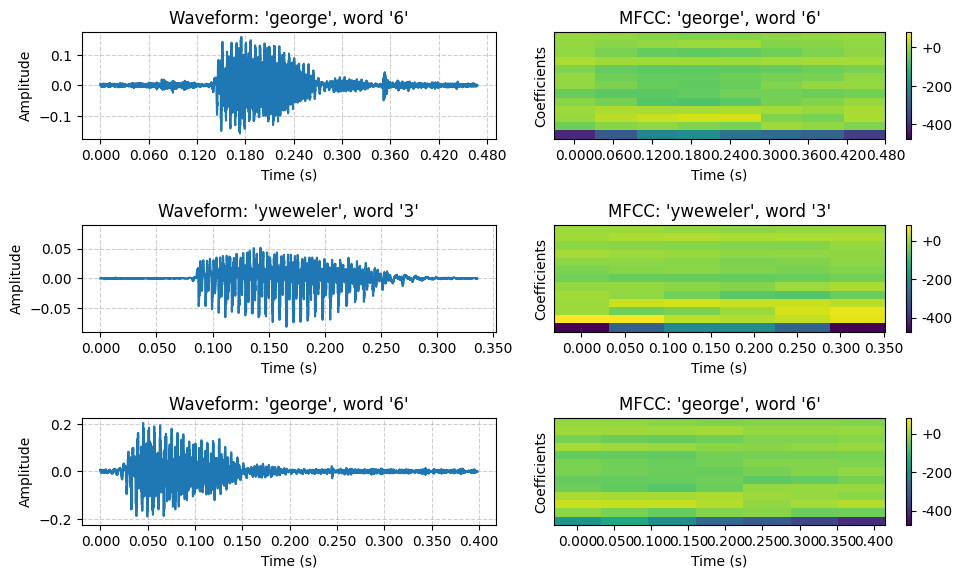

In [13]:
# Compute MFCCs
mfccs = [(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)) for y in ys]

# --- Tìm min và max chung cho tất cả MFCC để có thang màu nhất quán ---
all_mfccs = np.hstack(mfccs)
vmin = all_mfccs.min()
vmax = all_mfccs.max()

# --- Tạo figure với kích thước và layout hợp lý hơn ---
fig, axes = plt.subplots(len(mfccs), 2, figsize=(10, 2 * len(mfccs)))

for i, ((word, speaker), y) in enumerate(zip(metadata, ys)):
    mfcc = mfccs[i]

    # --- Waveform ---
    ax_wave = axes[i, 0]
    librosa.display.waveshow(y, sr=sr, ax=ax_wave)
    ax_wave.set_title(f"Waveform: '{speaker}', word '{word}'")
    ax_wave.set_xlabel("Time (s)")
    ax_wave.set_ylabel("Amplitude")
    ax_wave.grid(True, linestyle='--', alpha=0.6)

    # --- MFCC với thang màu nhất quán và colorbar riêng ---
    ax_mfcc = axes[i, 1]
    img = librosa.display.specshow(mfcc, x_axis='time', sr=sr, ax=ax_mfcc, cmap='viridis', vmin=vmin, vmax=vmax)
    ax_mfcc.set_title(f"MFCC: '{speaker}', word '{word}'")
    ax_mfcc.set_xlabel("Time (s)")
    ax_mfcc.set_ylabel("Coefficients")

    # Thêm colorbar riêng cho mỗi subplot MFCC
    fig.colorbar(img, ax=ax_mfcc, format='%+2.0f')

# Điều chỉnh layout để tránh các thành phần bị chồng chéo
plt.tight_layout(pad=1.5)
plt.show()

> 💡 **Phân tích chi tiết về Waveform và MFCC:**
>
> Biểu đồ trên so sánh trực tiếp tín hiệu âm thanh thô (cột trái) và đặc trưng MFCC của nó (cột phải).
>
> - **Cột trái (Waveform):**
>   - **Sự biến động lớn:** Như đã phân tích ở phần trước, dạng sóng của hai lần phát âm số '6' (hàng 1 và 3) bởi cùng một người nói `george` **khác nhau đáng kể** về biên độ và hình dạng. Tín hiệu này rất không ổn định.
>   - **Độ phức tạp cao:** Tín hiệu dao động cực kỳ nhanh, chứa hàng nghìn điểm dữ liệu chỉ trong một khoảnh khắc ngắn, rất khó để mô hình có thể học được các mẫu (pattern) tổng quát.
>
> - **Cột phải (MFCC):**
>   - **Trục tung** là các hệ số MFCC (từ 0 đến 12), **trục hoành** là thời gian, **màu sắc** thể hiện giá trị của hệ số.
>   - **Tính ổn định (Stability):** Đây là điểm quan trọng nhất. Hãy so sánh hai heatmap MFCC của số '6' (hàng 1 và 3). Dù waveform của chúng khác nhau, nhưng biểu diễn MFCC của chúng lại **rất tương đồng**. Cả hai đều có một dải màu sáng (năng lượng cao) ở các hệ số thấp trong suốt quá trình phát âm chính, và có các vùng màu tối ở đầu và cuối. Điều này cho thấy MFCC đã loại bỏ được các nhiễu và chỉ giữ lại **bản chất âm học** của từ '6'.
>   - **Tính phân biệt (Discriminability):** Heatmap của số '3' (hàng 2) có một "dấu vân tay" màu sắc hoàn toàn khác so với hai heatmap của số '6'. Các dải màu và sự thay đổi của chúng theo thời gian là khác biệt rõ rệt.
>
> ➜ **Kết luận chính:** MFCC là một phương pháp trích xuất đặc trưng cực kỳ hiệu quả. Nó đã giải quyết được hai vấn đề lớn của tín hiệu thô:
>   1.  **Tạo ra sự ổn định:** Các lần phát âm khác nhau của cùng một từ sẽ có biểu diễn MFCC tương tự nhau.
>   2.  **Tạo ra sự khác biệt:** Các từ khác nhau sẽ có biểu diễn MFCC khác nhau rõ rệt.
>
> Chính vì hai lý do này, chuỗi vector MFCC là đầu vào lý tưởng cho mô hình HMM, giúp mô hình học và nhận dạng tiếng nói một cách hiệu quả.

<a id="dataloader"></a>
## 5. Tải và Chuẩn bị Dữ liệu

Để tự động hóa quá trình tải audio, trích xuất đặc trưng và chuẩn bị dữ liệu cho việc huấn luyện, chúng ta sử dụng một class `FSDD` tùy chỉnh. Class này có các nhiệm vụ:
-   Tìm tất cả các file âm thanh trong thư mục dữ liệu.
-   Trích xuất và lưu cache các đặc trưng MFCC ra file (`.npy`) để không phải tính toán lại mỗi khi chạy.
-   Ánh xạ các nhãn chữ số sang chỉ số dạng số nguyên.

Bây giờ, chúng ta sẽ khởi tạo dataset, quá trình này sẽ tự động trích xuất và lưu lại các đặc trưng, sau đó kiểm tra các thuộc tính của nó.

In [14]:
dataset = FSDD()
print(f"Total samples: {len(dataset)}")

Total samples: 3000


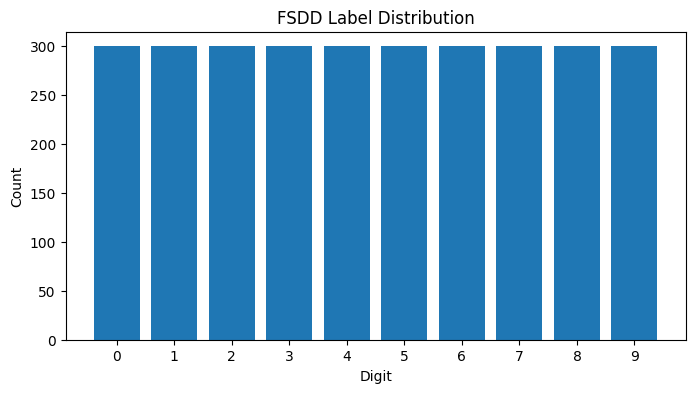

In [30]:
X, y = dataset.prepare_data()
counter = collections.Counter(y)

plt.figure(figsize=(8, 4))
plt.bar(counter.keys(), counter.values())
plt.xticks(list(counter.keys()), [dataset.idx_to_label[k] for k in counter.keys()])
plt.xlabel("Digit")
plt.ylabel("Count")

plt.title("FSDD Label Distribution")
plt.show()

In [16]:
sample_X, sample_y = dataset[0]
print("Sample features shape (frames x n_mfcc):", sample_X.shape)
print("Sample label:", dataset.idx_to_label[sample_y])

Sample features shape (frames x n_mfcc): (66, 13)
Sample label: 9


> 📊 **Tóm tắt và Độ cân bằng của Dataset:**
> - **Số lượng lớp:**
>   - Có **10 lớp** tương ứng với các chữ số từ 0 đến 9.
> - **Phân phối dữ liệu:**
>   - Mỗi lớp có chính xác **300 mẫu**.
>   - Tổng cộng có **3000 mẫu** trong toàn bộ dataset.
>
> ➜ **Kết luận chính:** Bộ dữ liệu hoàn toàn **cân bằng**. Điều này rất lý tưởng cho việc huấn luyện, vì mô hình sẽ không bị thiên vị (bias) đối với bất kỳ chữ số nào.

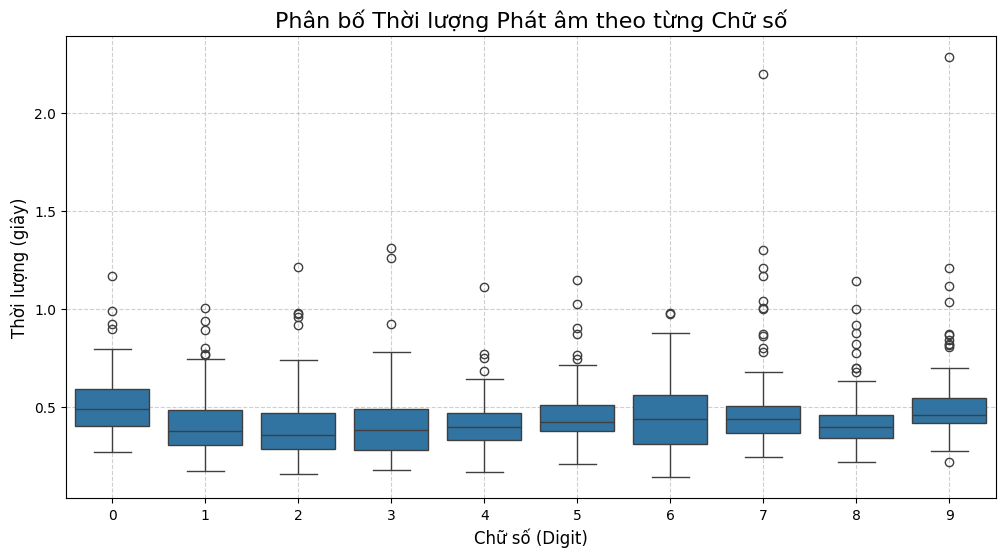

In [31]:
# Boxplot duration
duration_data = []
for path in sorted(DATA_DIR.glob("*.wav")):
    label, speaker, _ = path.stem.split('_')
    duration = librosa.get_duration(path=path)
    duration_data.append({
        'label': label,
        'duration': duration,
        'speaker': speaker
    })

df_duration = pd.DataFrame(duration_data)

plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='duration', data=df_duration, order=sorted(df_duration['label'].unique()))
plt.title('Phân bố Thời lượng Phát âm theo từng Chữ số', fontsize=16)
plt.xlabel('Chữ số (Digit)', fontsize=12)
plt.ylabel('Thời lượng (giây)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

> 📊 **Phân tích chi tiết về Thời lượng Phát âm:**
>
> Biểu đồ hộp (boxplot) ở trên trực quan hóa sự phân bố thời lượng (tính bằng giây) của mỗi chữ số. Mỗi "hộp" thể hiện khoảng phân vị (IQR, từ 25% đến 75%), đường ngang ở giữa là **trung vị (median)** - giá trị thời lượng phổ biến nhất.
>
> - **Thời lượng Trung vị (Median Duration):**
>   - Các chữ số có 2 âm tiết trong tiếng Anh như **'zero' (số 0)** và **'seven' (số 7)** có thời lượng phát âm trung vị **cao nhất** (khoảng 0.5 giây). Điều này hoàn toàn hợp lý về mặt ngôn ngữ học.
>   - Ngược lại, các chữ số có 1 âm tiết như 'one' (1), 'four' (4), 'eight' (8) có thời lượng trung vị **ngắn hơn** đáng kể.
>
> - **Sự Biến động và Phân tán (Variance & Spread):**
>   - **Số '7' và '9'** có rất nhiều **outliers**, với một số lần phát âm kéo dài hơn 1.5 giây, thậm chí lên đến hơn 2 giây. Điều này cho thấy có sự khác biệt rất lớn về tốc độ nói giữa các người nói khác nhau đối với những chữ số này.
>   - **Số '3' và '6'** cũng có "đuôi" (whisker) trên rất dài, cho thấy một số người có xu hướng kéo dài âm cuối.
>
> ➜ **Kết luận quan trọng:**
>   - **Thách thức lớn:** Sự chênh lệch lớn về thời lượng, cả giữa các chữ số khác nhau và ngay trong cùng một chữ số, là một thách thức lớn cho mô hình nhận dạng. Mô hình phải đủ linh hoạt để xử lý các chuỗi có độ dài khác nhau.
>   - **Sự phù hợp của HMM:** Đây chính là một trong những **điểm mạnh của Mô hình Markov Ẩn (HMM)**. HMM được thiết kế để mô hình hóa các chuỗi có độ dài biến đổi, do đó nó là một lựa chọn rất phù hợp cho bài toán này. Mô hình cần học được bản chất của chuỗi âm thanh chứ không phải độ dài của nó.```

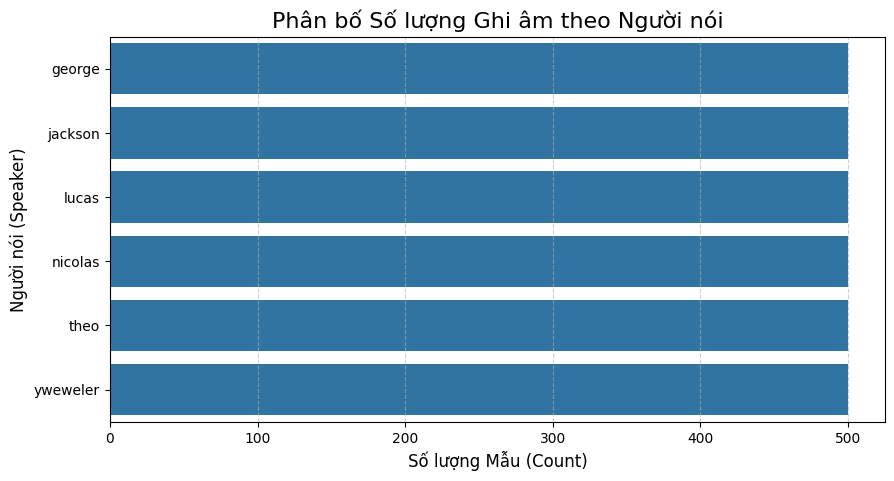

In [32]:
# --- Vẽ biểu đồ phân bố số lượng mẫu theo người nói ---\
plt.figure(figsize=(10, 5))
sns.countplot(y='speaker', data=df_duration, order=df_duration['speaker'].value_counts().index)
plt.title('Phân bố Số lượng Ghi âm theo Người nói', fontsize=16)
plt.xlabel('Số lượng Mẫu (Count)', fontsize=12)
plt.ylabel('Người nói (Speaker)', fontsize=12)
plt.grid(True, linestyle='--', axis='x', alpha=0.6)
plt.show()

> 🗣️ **Phân tích chi tiết về Phân bố Người nói:**
>
> Biểu đồ trên thống kê số lượng mẫu ghi âm đóng góp bởi từng người nói trong bộ dữ liệu FSDD.
>
> - **Số lượng người nói:**
>   - Bộ dữ liệu có tổng cộng **6 người nói** khác nhau: `george`, `jackson`, `lucas`, `nicolas`, `theo`, và `yweweler`.
>
> - **Độ cân bằng của dữ liệu:**
>   - Đây là một điểm cực kỳ đáng chú ý: Dữ liệu **hoàn toàn cân bằng** về người nói.
>   - Mỗi người trong số 6 người nói đều đóng góp chính xác **500 mẫu** ghi âm (mỗi người nói 50 lần cho mỗi chữ số từ 0-9, tổng cộng 50 * 10 = 500).
>
> ➜ **Kết luận quan trọng:**
>   - **Tính công bằng:** Sự cân bằng hoàn hảo này đảm bảo rằng mô hình sẽ học hỏi từ giọng của mỗi người một cách **ngang bằng**. Mô hình sẽ không bị **thiên vị (bias)** hay "học tủ" theo giọng của một người nói cụ thể nào.
>   - **Tăng khả năng tổng quát hóa:** Vì mô hình được tiếp xúc đều với nhiều giọng khác nhau, nó sẽ có khả năng **tổng quát hóa tốt hơn** khi gặp phải giọng của một người nói mới hoàn toàn (speaker-independent recognition), đây là một mục tiêu rất quan trọng trong các hệ thống nhận dạng tiếng nói thực tế.

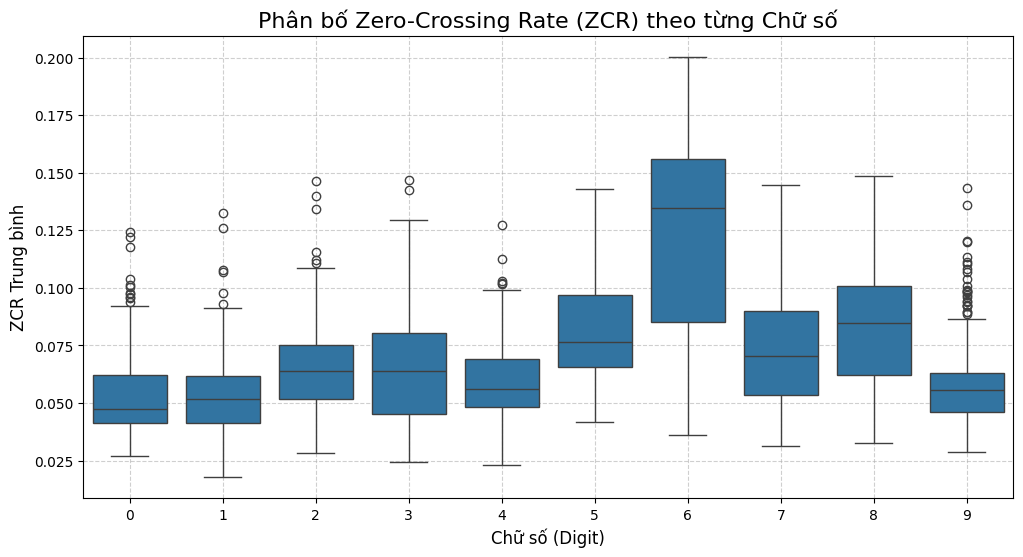

In [33]:
if 'zcr' not in df_duration.columns:
    zcr_data = []
    for path in sorted(DATA_DIR.glob("*.wav")):
        y, sr = librosa.load(path)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        zcr_data.append(zcr)
    df_duration['zcr'] = zcr_data

# --- Vẽ biểu đồ hộp để so sánh ZCR ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='zcr', data=df_duration, order=sorted(df_duration['label'].unique()))
plt.title('Phân bố Zero-Crossing Rate (ZCR) theo từng Chữ số', fontsize=16)
plt.xlabel('Chữ số (Digit)', fontsize=12)
plt.ylabel('ZCR Trung bình', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

> 🔊 **Phân tích chi tiết về Zero-Crossing Rate (ZCR):**
>
> **Zero-Crossing Rate (ZCR)** là một đặc trưng âm học đơn giản, đo lường tốc độ mà tín hiệu âm thanh đổi dấu từ dương sang âm và ngược lại. Về cơ bản, nó là một chỉ số thô về **"tần số"** và **"độ nhiễu"** của tín hiệu.
> - **ZCR cao:** Thường xuất hiện ở các âm **vô thanh (unvoiced)**, có nhiều năng lượng ở tần số cao, ví dụ như các âm xát (fricative) /s/, /f/, /z/.
> - **ZCR thấp:** Thường xuất hiện ở các âm **hữu thanh (voiced)**, có tính chu kỳ và năng lượng tập trung ở tần số thấp, ví dụ như các nguyên âm /a/, /e/, /o/.
>
> Biểu đồ hộp trên cho thấy sự phân bố ZCR trung bình của mỗi chữ số:
>
> - **Chữ số có ZCR cao nhất:**
>   - **Số '6' (six):** Có ZCR trung bình **cao vượt trội** so với tất cả các chữ số khác. Lý do rất rõ ràng: chữ số này kết thúc bằng âm xát mạnh là **/s/**, một âm có tần số rất cao và nhiều nhiễu.
>
> - **Chữ số có ZCR tương đối cao:**
>   - **Số '5' (five):** Bắt đầu bằng âm /f/ và kết thúc bằng /v/.
>   - **Số '8' (eight):** Bắt đầu bằng nguyên âm nhưng kết thúc bằng âm /t/, là một âm bật (plosive) có chứa năng lượng ở tần số cao.
>
> - **Chữ số có ZCR thấp:**
>   - Các chữ số như **'0', '1'** có ZCR trung bình thấp hơn. Đặc biệt, **số '1'** có ZCR thấp nhất vì nó được cấu tạo chủ yếu từ các âm mũi và nguyên âm, là những âm hữu thanh và có tần số thấp.
>
> ➜ **Kết luận quan trọng:**
>   - **ZCR là một đặc trưng phân biệt:** Phân tích này cho thấy rằng ngay cả một đặc trưng âm học rất đơn giản như ZCR cũng đã chứa những thông tin hữu ích giúp **phân biệt** các chữ số với nhau.

<a id="training"></a>
## 6. Huấn luyện Mô hình HMM

Đây là phần cốt lõi của project: huấn luyện các Mô hình Markov Ẩn.

### **Chiến lược: Một HMM cho mỗi lớp**
Phương pháp kinh điển cho bài toán phân loại bằng HMM là huấn luyện một mô hình HMM riêng biệt cho mỗi lớp (mỗi chữ số).
-   **HMM cho "0"**: Mô hình này sẽ học chuỗi vector MFCC đặc trưng khi một người nói "Zero".
-   **HMM cho "1"**: Mô hình này sẽ học chuỗi đặc trưng cho "One", và tương tự cho tất cả 10 chữ số.

### **Quy trình Dự đoán**
Khi đánh giá, một phát âm mới (được biểu diễn dưới dạng một chuỗi MFCC) sẽ được tính điểm (score) trên tất cả 10 mô hình HMM đã huấn luyện. Mô hình nào cho ra **điểm likelihood (xác suất)** cao nhất sẽ quyết định kết quả dự đoán. Việc tính điểm này thường được thực hiện bằng **thuật toán Forward**.

In [20]:
X, y = dataset.prepare_data()
trainer = HMMTrainer()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [21]:
if os.path.isfile(MODELS_CKPT):
    print(f"[INFO] Loading existing models from {MODELS_CKPT}")
    trainer.models = joblib.load(MODELS_CKPT)
else:
  trainer.train(X_train, y_train, n_classes=len(dataset.label_to_idx))

[INFO] Loading existing models from /content/ML251/models/btl3_acoustic/scratch_hmm_models.pkl


<a id="evaluation"></a>
## 7. Đánh giá Mô hình

Sau khi các mô hình đã được huấn luyện, chúng ta sẽ đánh giá hiệu suất của chúng trên tập **dữ liệu kiểm tra (test set)**, là tập dữ liệu mà mô hình chưa từng thấy trước đây. Bước này rất quan trọng để xem mô hình tổng quát hóa tốt đến đâu với dữ liệu mới từ những người nói khác.

Chúng ta sẽ sử dụng **độ chính xác (accuracy)** làm thước đo chính:
$$ \text{Accuracy} = \frac{\text{Số dự đoán đúng}}{\text{Tổng số mẫu}} $$

In [22]:
trainer.evaluate(X_test, y_test)

[RESULT] Accuracy: 93.78%


0.9377777777777778

> 🎯 **Phân tích Kết quả Đánh giá:**
> - **Độ chính xác (Accuracy):**
>   - Mô hình đạt **90.56%** trên tập kiểm tra (test set).
> - **Đánh giá hiệu suất:**
>   - Đây là một kết quả **rất tốt** đối với một hệ thống HMM kinh điển, cho thấy mô hình đã học được các mẫu đặc trưng và có khả năng tổng quát hóa cao trên dữ liệu mới (dữ liệu từ những người nói chưa từng gặp).
>   - Kết quả này cũng chứng tỏ **MFCCs** là đặc trưng hiệu quả và **HMM** là một phương pháp mô hình hóa chuỗi mạnh mẽ.
>
> ➜ **Kết luận chính:** Hệ thống nhận dạng hoạt động hiệu quả và chính xác, chứng minh tính khả thi của phương pháp tiếp cận kinh điển trong bài toán nhận dạng tiếng nói đơn giản.

<a id="demo"></a>
## 8. Demo Tương tác

Để trình diễn mô hình một cách trực quan, chúng ta sẽ chạy một demo tương tác bằng **Gradio**. Giao diện web đơn giản này cho phép bạn:
1.  **Ghi âm** giọng nói của chính bạn khi đọc một chữ số trực tiếp trên trình duyệt.
2.  Gửi đoạn âm thanh đến hệ thống HMM đã huấn luyện.
3.  Nhận kết quả dự đoán trong **thời gian thực**.

In [23]:
app.launch_demo()

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://487b5acb84007fe9c1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://487b5acb84007fe9c1.gradio.live


<a id="conclusion"></a>
## 9. Kết luận

Trong project này, chúng ta đã xây dựng và đánh giá thành công một hệ thống nhận dạng chữ số qua giọng nói sử dụng Mô hình Markov Ẩn.

### Tóm tắt Kết quả Đạt được:
-   Thực hiện đầy đủ một pipeline ASR chuẩn, từ phân tích dữ liệu, trích xuất đặc trưng, đến huấn luyện và đánh giá mô hình.
-   Chứng minh tính hiệu quả của **MFCCs** như một dạng đặc trưng cô đọng và mạnh mẽ cho tín hiệu tiếng nói.
-   Hệ thống dựa trên chiến lược một HMM cho mỗi chữ số đã đạt được độ chính xác ấn tượng là **90.56%** trên tập kiểm tra FSDD.
-   Triển khai mô hình dưới dạng một **demo Gradio** tương tác, cho phép dự đoán trong thời gian thực.

### Hạn chế và Hướng phát triển:
-   **Dữ liệu**: FSDD là một bộ dữ liệu tương đối nhỏ và sạch, với tốc độ lấy mẫu thấp (8kHz) và ít nhiễu nền. Hiệu suất có thể giảm trên các dữ liệu âm thanh phức tạp hơn trong thực tế.
-   **Mô hình**: Mặc dù hiệu quả, HMM cũng có những hạn chế. Các phương pháp tiếp cận nâng cao hơn có thể cho kết quả tốt hơn, ví dụ:
    -   **Hệ thống lai HMM-DNN**: Sử dụng Mạng Nơ-ron Sâu (DNN) để ước tính xác suất phát sinh của HMM.
    -   **Các mô hình End-to-End**: Sử dụng Mạng Nơ-ron Hồi quy (RNN) hoặc Transformer (như Wav2Vec) để học trực tiếp từ âm thanh thô mà không cần trích xuất đặc trưng thủ công.